In [2]:
import numpy as np
import matplotlib.pyplot as plt
from euler_cromer import simulate

In [3]:
def normalize(v):
    if not np.any(v): return v
    else: return v / np.linalg.norm(v)

In [4]:
rho = 1.2  # luftens densitet
g = 9.82  # gravitation

class ThrowObject():
    def __init__(self, m, C_d, A, r=None, omega=0):
        self.m = m # massa
        self.C_d = C_d # luftmotståndskonstant
        self.A = A # tvärsnittsarea
        self.r = r # radie
        self.k_d = 0.5 * C_d * rho * A
        self.omega = omega # vinkelhastighet motsols

    def set_initial(self, y0, v0, alpha=None):
        # Specifiera antingen (y0, fart, vinkel) eller vektorer y0, v0
        if alpha is not None and isinstance(v0, (float, int)):
            self.v0 = np.array([v0 * np.cos(alpha), v0 * np.sin(alpha)])
        elif (hasattr(y0, '__iter__') and hasattr(v0, '__iter__')):
            self.v0 = v0
        else: raise ValueError()
        self.y0 = y0
        self.initial = [self.y0, self.v0]

    # acceleration vid kast utan luftmotstånd, bara gravitation
    def acceleration_gravity(self, y, v, t):
        return np.array([0, -g])
    # luftmotstånd + gravitation
    def acceleration_drag(self, y, v, t):
        Fd = -v * self.k_d * np.linalg.norm(v) # riktning: -v, magnitud: k_d*|v|^2
        Fg = np.array([0, -self.m * g]) # gravitationskraft
        return (Fd + Fg) / self.m
    # luftmotstånd + gravitation + magnuseffekt
    def acceleration_magnus(self, y, v, t):
        magnitude = 2*rho*self.omega*np.linalg.norm(v)*self.r*self.A
        direction = normalize(np.array([-v[1], v[0]])) # vinkelrät mot hastighet
        a_magnus = (direction * magnitude) / self.m
        return a_magnus + self.acceleration_drag(y, v, t)

class Sphere(ThrowObject):
    def __init__(self, r, m, C_d=0.47, omega=0):
        super().__init__(m, C_d, A=np.pi*r**2, r=r, omega=omega)

### Jämför med och utan luftmotstånd

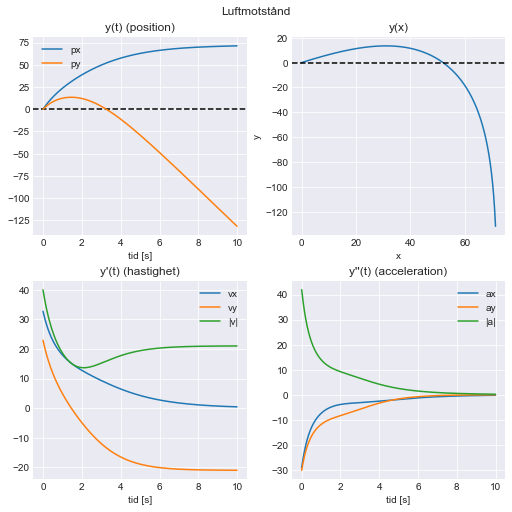

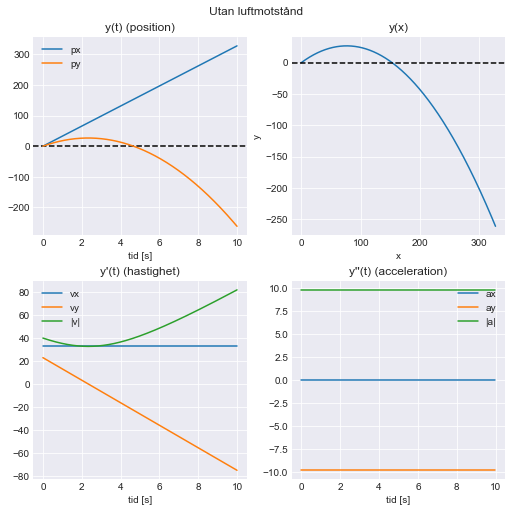

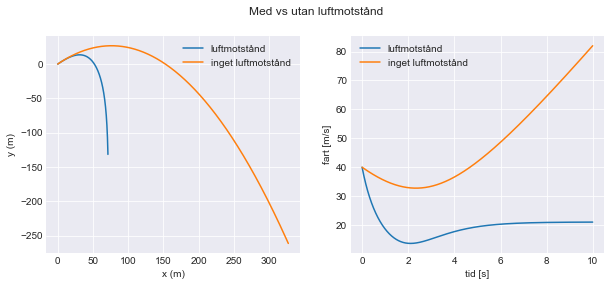

In [11]:
def compare_pos_speed(sol_a, sol_b, labels, title=''):
    fig, axs = plt.subplot_mosaic('ab', figsize=(10, 4))
    fig.suptitle(title)
    axs['a'].plot(np.column_stack((sol_a['x'], sol_b['x'])), np.column_stack((sol_a['y'], sol_b['y'])), label=labels)
    axs['a'].legend()
    axs['a'].set_xlabel('x (m)'); axs['a'].set_ylabel('y (m)')
    axs['b'].plot(sol_a['t'], np.column_stack((sol_a['speed'], sol_b['speed'])), label=labels)
    axs['b'].legend()
    axs['b'].set_xlabel('tid [s]'); axs['b'].set_ylabel('fart [m/s]')
    
ball = Sphere(0.1, 0.4)
ball.set_initial(y0=[0, 0], v0=40, alpha=np.radians(35))
dt, to_time = 0.01, 10

drag = simulate(ball.acceleration_drag, ball.initial, dt=dt, to_time=to_time, plot=True, title="Luftmotstånd")
no_drag = simulate(ball.acceleration_gravity, ball.initial, dt=dt, to_time=to_time, plot=True, title="Utan luftmotstånd")

compare_pos_speed(drag, no_drag, ['luftmotstånd', 'inget luftmotstånd'], title='Med vs utan luftmotstånd')

### Jämför boll och människa

terminalhastighet människa: 52.058793577944044 m/s


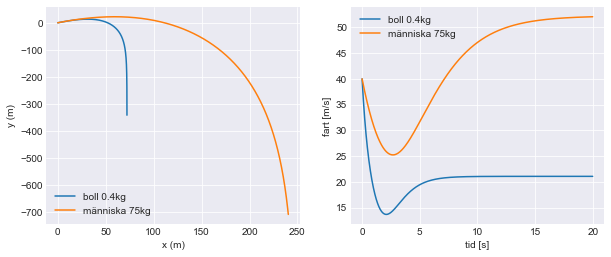

In [23]:
ball = Sphere(r=0.1, m=0.4)
human = ThrowObject(m=75, C_d=1, A=0.45)
y0, v0, alpha = [0, 0], 40, np.radians(35)
human.set_initial(y0, v0, alpha); ball.set_initial(y0, v0, alpha)
sol_human = simulate(human.acceleration_drag, human.initial, to_time=20, plot=False)
sol_ball = simulate(ball.acceleration_drag, ball.initial, to_time=20, plot=False)

print('terminalhastighet människa:', sol_human['speed'][-1], 'm/s')
compare_pos_speed(sol_ball, sol_human, labels=['boll 0.4kg', 'människa 75kg'])

### Jämför olika begynnelsehastigheter

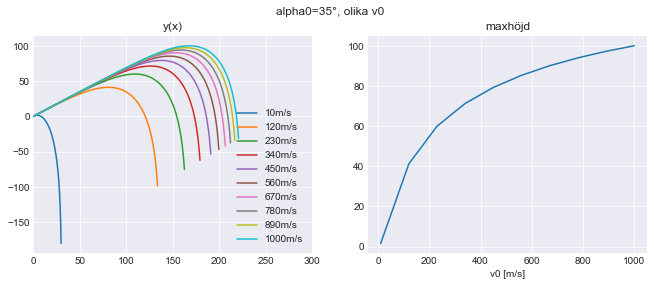

In [67]:
vs = np.linspace(10, 1000, 10)
top_speeds, max_heights, max_lengths, ys, xs = [], [], [], [], []
for v in vs:
    sphere = Sphere(r=0.1, m=0.5)
    sphere.set_initial(y0=[0, 0], v0=v, alpha=np.radians(35))
    res = simulate(sphere.acceleration_drag, sphere.initial, dt=0.01, to_time=10, plot=False)
    top_speeds.append(np.linalg.norm(res['y_prime'], axis=1)[-1])
    max_heights.append(res['y'].max())
    ys.append(res['y'])
    xs.append(res['x'])
    time = res['t']

    maxlen = res['x'][np.nonzero(res['y'] < 0)[0][0]]
    max_lengths.append(maxlen)

fig, axs = plt.subplots(1, 2, figsize=(11, 4))
fig.suptitle('alpha0=35°, olika v0')
axs[0].plot(np.array(xs).T, np.array(ys).T, label=list(map(lambda v: f'{v:.0f}m/s', vs)))
axs[0].legend(loc='lower right'); axs[0].set_xlim(0, 300)
axs[0].set_title('y(x)')
axs[1].plot(vs, max_heights)
axs[1].set_title('maxhöjd')
axs[1].set_xlabel('v0 [m/s]')
plt.show()

# best_alpha = alphas[np.argmax(max_lengths)]; print(best_alpha)
# plt.scatter(alphas, max_lengths, s=5)
# plt.axvline(best_alpha, color='k', linestyle='--')
# plt.title('sträcka i x-led tills y=0 för olika startvinklar, v0=40m/s')
# plt.ylabel('x [m]'); plt.xlabel('alpha0 [grader]')

### Jämför olika värden på tidssteget dt

dt=1s: -188.469m felmarginal
dt=0.1s: -18.935m felmarginal
dt=0.01s: -1.894m felmarginal
dt=0.001s: -0.189m felmarginal


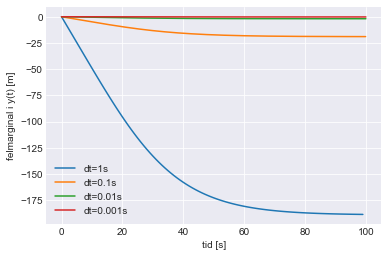

In [8]:
def exact_solution(t, obj):
    # analytisk lösning y(t) för fall med luftmotstånd 
    # från https://en.wikipedia.org/wiki/Free_fall

    y0, m, A, C_d = obj.y0, obj.m, obj.A, obj.C_d

    vel_terminal = np.sqrt((2*m*g) / (rho*C_d*A))
    y = y0[1] - (vel_terminal**2 / g) * np.log(np.cosh((g*t)/vel_terminal))
    return y

ball = Sphere(0.01, 0.5)
ball.set_initial(y0=[0, 10], v0=[0, 0]) # släpp från 10m
for dt in [1, 0.1, 0.01, 0.001]:
    res = simulate(ball.acceleration_drag, ball.initial, dt=dt, to_time=100, plot=False)
    y_true = exact_solution(res['t'], ball)
    plt.plot(res['t'], res['y'] - y_true, label=f'dt={dt}s')
    print(f"dt={dt}s: {res['y'][-1] - y_true[-1]:.3f}m felmarginal")
plt.xlabel('tid [s]'); plt.ylabel('felmarginal i y(t) [m]')
plt.legend()
plt.show()

### Extrauppgift 2

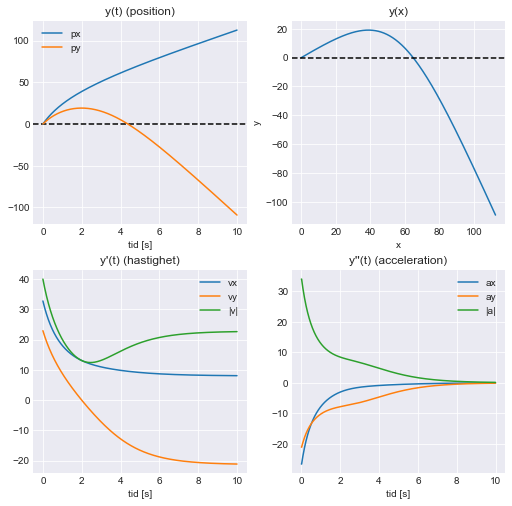

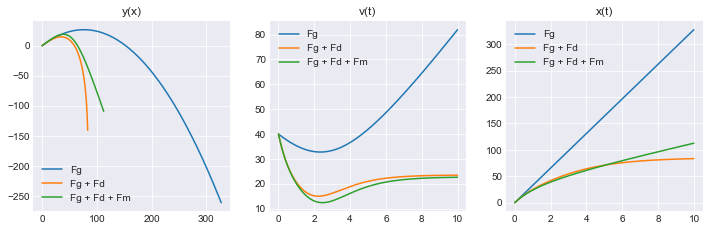

In [9]:
ball = Sphere(0.1, 0.5, omega=10)
ball.set_initial([0, 0], 40, np.radians(35))
dt, to_time = 0.01, 10
gravity = simulate(ball.acceleration_gravity, ball.initial, dt=dt, to_time=to_time, plot=False)
drag = simulate(ball.acceleration_drag, ball.initial, dt=dt, to_time=to_time, plot=False)
magnus = simulate(ball.acceleration_magnus, ball.initial, dt=dt, to_time=to_time, plot=True)

ys = np.column_stack((gravity['y'], drag['y'], magnus['y']))
xs = np.column_stack((gravity['x'], drag['x'], magnus['x']))
vs = np.column_stack((gravity['speed'], drag['speed'], magnus['speed']))

fig, axs = plt.subplot_mosaic('abc', figsize=(12, 3.5))
axs['a'].plot(xs, ys, label=['Fg', 'Fg + Fd', 'Fg + Fd + Fm'])
axs['a'].set_title('y(x)')
axs['a'].legend()
axs['b'].plot(gravity['t'], vs, label=['Fg', 'Fg + Fd', 'Fg + Fd + Fm'])
axs['b'].set_title('v(t)')
axs['b'].legend()
axs['c'].plot(gravity['t'], xs, label=['Fg', 'Fg + Fd', 'Fg + Fd + Fm'])
axs['c'].set_title('x(t)')
axs['c'].legend()

Text(0, 0.5, 'y')

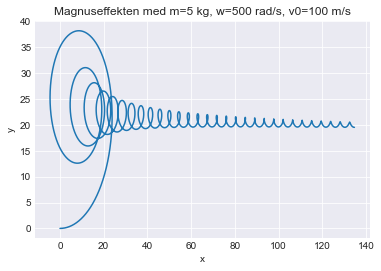

In [68]:
ball = Sphere(0.1, 1, omega=500)
ball.set_initial([0, 0], 100, alpha=np.radians(0))
a = simulate(ball.acceleration_magnus, ball.initial, dt=0.001, to_time=50, plot=False)
plt.plot(a['x'], a['y'])
plt.title("Magnuseffekten med m=5 kg, w=500 rad/s, v0=100 m/s")
plt.xlabel('x'); plt.ylabel('y')